In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]    = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [ ]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())


In [1]:
#!/usr/bin/python
# simple mnist experiment

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# import variational_dropout as vd


In [2]:
def fully_connected(x, 
                    phase, 
                    n_hidden, 
                    activation_fn=tf.nn.relu, 
                    thresh=3,
                    initializer=tf.contrib.layers.xavier_initializer, 
                    scope=None):

    # you get xavier initialization, and that's it for now
    n_input     = int(x.shape[1])
    print('n_input = %s' % n_input)
    w           = tf.get_variable(name="w", 
                                  shape=[n_input, n_hidden], 
                                  initializer=initializer())
    b           = tf.get_variable(name="b", 
                                  shape=[n_hidden,], 
                                  initializer=tf.constant_initializer(0.))

    ard_init    = -10.
    log_sigma2  = tf.get_variable(name="log_sigma2", 
                                  shape=[n_input, n_hidden], 
                                  initializer=tf.constant_initializer(ard_init))
    
    eps         = 1e-8
    log_alpha   = tf.clip_by_value(t=(log_sigma2 - tf.log(tf.square(w) + eps)),
                                   clip_value_min=-8., 
                                   clip_value_max=8., 
                                   name='log_alpha')
    # log_alpha   = tf.identity(log_alpha, name='log_alpha') # <- not need...

    # at test time,we just mask
    select_mask = tf.cast(x=tf.less(x=log_alpha, y=thresh), 
                          dtype=tf.float32)
    fc_masked   = tf.matmul(a=x, b=(w * select_mask))

    # choose between adding noise, or applying mask, depending on phase
    mu          = tf.matmul(a=x, b=w)
    si          = tf.sqrt(x=tf.matmul(a=tf.square(x), b=(tf.exp(log_alpha) * tf.square(w))) + eps)
    fc_noisy    = mu + (si * tf.random_normal(shape=tf.shape(mu), 
                                              mean=0.0,
                                              stddev=1.0))

    activations = tf.cond(pred=phase, true_fn=(lambda:fc_noisy), false_fn=(lambda:fc_masked))
    
    return activation_fn(activations + b)


In [3]:
# def conv2d(x, 
#            phase, 
#            n_filters, 
#            kernel_size, 
#            activation_fn=tf.nn.relu,
#            strides=[1,1,1,1],
#            initializer=tf.contrib.layers.xavier_initializer_conv2d, 
#            thresh=3,
#            padding='SAME', 
#            scope=None, 
#            bias=False):
    
#     n_input_channels = int(x.shape[3])
#     # define parameters
#     conv_param_shape = kernel_size + [n_input_channels, n_filters]
#     w                = tf.get_variable("w", conv_param_shape, initializer=initializer())
    
#     if (bias):
#         b = tf.get_variable("b", [n_filters], initializer=tf.constant_initializer())

#     # homemade initializers
#     ard_init      = -10.
#     log_sigma2    = tf.get_variable("log_sigma2", shape=conv_param_shape, initializer=tf.constant_initializer(ard_init))
    
#     eps           = 1e-8
#     log_alpha     = tf.clip_by_value((log_sigma2 - tf.log(tf.square(w) + eps)), -8., 8.)
#     log_alpha     = tf.identity(log_alpha, name='log_alpha')

#     select_mask   = tf.cast(tf.less(log_alpha, thresh), tf.float32)

#     conved_mu     = tf.nn.conv2d(x, w, strides=strides, padding=padding)
#     conved_si     = tf.sqrt(tf.nn.conv2d(tf.square(x),
#                                          tf.exp(log_alpha)*tf.square(w),
#                                          strides=strides, 
#                                          padding=padding)+1e-8)
#     conv2d_noisy  = conved_mu + tf.random_normal(tf.shape(conved_mu))*conved_si
    
#     conv2d_masked = tf.nn.conv2d(x, w*select_mask, strides=strides, padding=padding)
    
#     activations   = tf.cond(phase, lambda: conv2d_noisy, lambda: conv2d_masked)
#     if bias:
#         return activation_fn(activations + b)
#     else:
#         return activation_fn(activations)


In [4]:
def deepnn(x, phase):
    """
    Builds the network graph.

    Args:
        x: an input tensor with the dimensions (N_examples, 784), where 784 is the
        number of pixels in a standard MNIST image.
        x: True is train, False is test

    Returns:
        A tuple (y, log_alphas). y is a tensor of shape (N_examples, 10), with values
        equal to the logits of classifying the digit into one of 10 classes (the
        digits 0-9). log_alphas is a list of the log_alpha parameters describing
        the effective dropout rate of the approximate posterior.
    """
    
#     # Reshape to use within a convolutional neural net.
#     # Last dimension is for "features" - there is only one here, since images are
#     # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
#     with tf.variable_scope('reshape', reuse=tf.AUTO_REUSE):
#         x_image      = tf.reshape(x, [-1, 28, 28, 1])

#     # First convolutional layer - maps one grayscale image to 32 feature maps.
#     with tf.variable_scope('conv1', reuse=tf.AUTO_REUSE):
#         h_conv1      = conv2d(x_image, phase, 32, [5,5])
    
#     # Pooling layer - downsamples by 2X.
#     with tf.variable_scope('pool1', reuse=tf.AUTO_REUSE):
#         # max_pool_2x2 downsamples a feature map by 2X.
#         h_pool1      = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#     # Second convolutional layer -- maps 32 feature maps to 64.
#     with tf.variable_scope('conv2', reuse=tf.AUTO_REUSE):
#         h_conv2      = conv2d(h_pool1, phase, 64, [5,5])

#     # Second pooling layer.
#     with tf.variable_scope('pool2', reuse=tf.AUTO_REUSE):
#         # max_pool_2x2 downsamples a feature map by 2X.
#         h_pool2      = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#     # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
#     # is down to 7x7x64 feature maps -- maps this to 1024 features.
#     with tf.variable_scope('fc1', reuse=tf.AUTO_REUSE):
#         h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
#         h_fc1        = fully_connected(h_pool2_flat, phase, 1024)

    # 
    with tf.variable_scope('fc1', reuse=tf.AUTO_REUSE):
        h_fc1        = fully_connected(x=x, phase=phase, n_hidden=20)

    # Map the 1024 features to 10 classes, one for each digit
    with tf.variable_scope('fc2', reuse=tf.AUTO_REUSE):
        y_conv       = fully_connected(h_fc1, phase, 10) 
    
    return y_conv


In [5]:
# Define placeholders
x     = tf.placeholder(tf.float32, [None, 784])
y_    = tf.placeholder(tf.float32, [None, 10])
phase = tf.placeholder(tf.bool, None)


In [6]:
# Build the graph for the deep net
y_conv = deepnn(x, phase)


n_input = 784
n_input = 20


In [7]:
# Import data
mnist = input_data.read_data_sets('/tmp/tensorflow/mnist/input_data', one_hot=True)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [8]:
# with tf.name_scope('loss'):
#     # cross entropy part of the ELBO
#     cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_,
#                                                         logits=y_conv))
#     # prior DKL part of the ELBO
#     log_alphas = gather_logalphas(tf.get_default_graph())
#     divergences = [dkl_qp(la) for la in log_alphas]
#     # combine to form the ELBO
#     N = float(mnist.train.images.shape[0])
#     dkl = tf.reduce_sum(tf.stack(divergences))
#     elbo = cross_entropy+(1./N)*dkl

# cross entropy part of the ELBO
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# prior DKL part of the ELBO
# utility to gather variational dropout parameters
node_defs     = [n for n in tf.get_default_graph().as_graph_def().node if 'log_alpha' in n.name]
tensors       = [tf.get_default_graph().get_tensor_by_name(n.name+":0") for n in node_defs]
log_alphas    = tensors

k1, k2, k3    = 0.63576, 1.8732, 1.48695
C             = -k1

divergences   = []
for la in log_alphas:
    print('aaa')
    mdkl      = k1 * tf.nn.sigmoid(k2 + k3 * la) - 0.5 * tf.log1p(tf.exp(-la)) + C
    dkl_qp    = -tf.reduce_sum(mdkl)

    divergences.append(dkl_qp)

# combine to form the ELBO
N             = float(mnist.train.images.shape[0])
dkl           = tf.reduce_sum(tf.stack(divergences))
elbo          = cross_entropy + (1. / N) * dkl


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

aaa
aaa
aaa
aaa
aaa
aaa
aaa
aaa


In [9]:
train_step = tf.train.AdamOptimizer(1e-3).minimize(elbo)


In [10]:
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy           = tf.reduce_mean(correct_prediction)


In [11]:
# handy function to keep track of sparsity
thresh   = 3
N_active = 0.
N_total  = 0.
for la in log_alphas:
    m         = tf.cast(tf.less(la, thresh), tf.float32)
    n_active  = tf.reduce_sum(m)
    n_total   = tf.cast(tf.reduce_prod(tf.shape(m)), tf.float32)
    N_active += n_active
    N_total  += n_total
sparse = 1.0 - N_active / N_total


In [47]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(5001):
    batch = mnist.train.next_batch(50)
    if i % 1000 == 0:
        train_accuracy, train_loss = sess.run((accuracy, elbo), feed_dict={x: batch[0], y_: batch[1], phase: False})
        print('step %d, training accuracy %g, training loss: %g' % (i, train_accuracy, train_loss))
        val_x, val_y = mnist.validation.next_batch(50)
        val_accuracy, val_loss, val_sp = sess.run((accuracy, cross_entropy, sparse), feed_dict={x: val_x, y_: val_y, phase: False})
        print('step %d, val accuracy %g, val loss: %g, sparsity: %g' % (i, val_accuracy, val_loss, val_sp))
    train_step.run(session=sess, feed_dict={x: batch[0], y_: batch[1], phase: True})


step 0, training accuracy 0.12, training loss: 3.56891
step 0, val accuracy 0.14, val loss: 2.33661, sparsity: 0.0166855
step 1000, training accuracy 0.74, training loss: 0.975878
step 1000, val accuracy 0.78, val loss: 0.594826, sparsity: 0.667674
step 2000, training accuracy 0.98, training loss: 0.448132
step 2000, val accuracy 0.98, val loss: 0.219397, sparsity: 0.672648
step 3000, training accuracy 0.96, training loss: 0.398901
step 3000, val accuracy 0.96, val loss: 0.147494, sparsity: 0.682408
step 4000, training accuracy 0.86, training loss: 0.641695
step 4000, val accuracy 0.96, val loss: 0.315624, sparsity: 0.680645


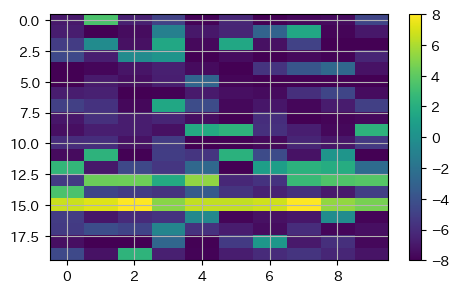

sum = -3423.1675


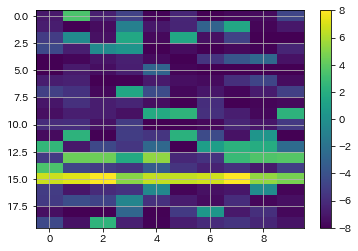

sum = -3423.1675


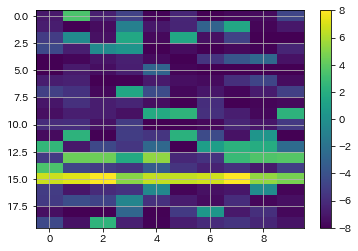

sum = -622.78577


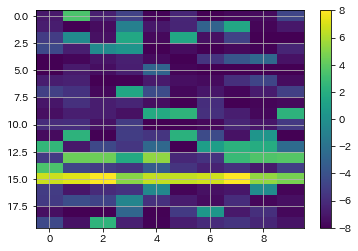

sum = -622.46924


In [46]:
import matplotlib
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,15),dpi=100)

for i in [1, 3, 5, 7]:
    la_tmp = sess.run(log_alphas[i])
    fig.add_subplot(4, 2, (i + 1))
    plt.grid(which='major',color=[0.7, 0.7, 0.7],linestyle='-')
    plt.imshow(tmp, aspect='auto')
    plt.colorbar()
    plt.show()
    print('sum = %s' % np.sum(k1 * (1 / (1 + np.exp(-(k2 + k3 * la_tmp)))) - (0.5 * np.log(1 + np.exp(-la_tmp))) + C))


In [42]:
k1 * (1 / (k2 + k3 * la_tmp)) - (0.5 * np.log(1 + np.exp(-la_tmp))) + C

array([[-0.58975375, -0.58975375, -0.58975375, ..., -0.58975375,
        -0.58975375, -0.58975375],
       [-0.58975375, -0.58975375, -0.58975375, ..., -0.58975375,
        -0.58975375, -0.58975375],
       [-0.58975375, -0.58975375, -0.58975375, ..., -0.58975375,
        -0.58975375, -0.58975375],
       ...,
       [-0.58975375, -0.58975375, -0.58975375, ..., -0.58975375,
        -0.58975375, -0.58975375],
       [-0.58975375, -0.58975375, -0.58975375, ..., -0.58975375,
        -0.58975375, -0.58975375],
       [-0.58975375, -0.58975375, -0.58975375, ..., -0.58975375,
        -0.58975375, -0.58975375]], dtype=float32)

In [40]:
np.shape(0.5 * np.log(1 + np.exp(-la_tmp)))

(784, 20)

In [24]:
sess.run(divergences[7])

622.4693

In [26]:
sess.run(dkl)

8100.9175

In [ ]:
print('test accuracy %g' % accuracy.eval(session=sess, feed_dict={x: mnist.test.images, y_: mnist.test.labels, phase: False}))


In [ ]:
threshold_sparse = 0.1

w_1_tmp = sess.run(tf.trainable_variables('fc1/w:0'))[0].ravel()
w_2_tmp = sess.run(tf.trainable_variables('fc2/w:0'))[0].ravel()

import numpy             as np
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(12,8),dpi=100)

ax  = plt.subplot(2, 2, 1)
plt.hist(w_1_tmp, bins=50, log=True)

ax  = plt.subplot(2, 2, 2)
plt.hist(w_2_tmp, bins=50, log=True)

ax  = plt.subplot(2, 2, 3)
plt.plot(np.sort(w_1_tmp))

ax  = plt.subplot(2, 2, 4)
plt.plot(np.sort(w_2_tmp))

plt.show()

print(np.sum(np.abs(w_1_tmp) <= threshold_sparse) / len(w_1_tmp))
print(np.sum(np.abs(w_2_tmp) <= threshold_sparse) / len(w_2_tmp))


In [ ]:
w_1 = sess.run(tf.trainable_variables('fc1/w:0'))[0]
w_1[np.abs(w_1) < threshold_sparse] = 0
w_2 = sess.run(tf.trainable_variables('fc2/w:0'))[0]
w_2[np.abs(w_2) < threshold_sparse] = 0


In [ ]:
tmp = tf.trainable_variables('fc1/w:0')
tmp[0].load(w_1, sess)
tmp = tf.trainable_variables('fc2/w:0')
tmp[0].load(w_2, sess)


In [ ]:
w_1_tmp = sess.run(tf.trainable_variables('fc1/w:0'))[0].ravel()
w_2_tmp = sess.run(tf.trainable_variables('fc2/w:0'))[0].ravel()


fig = plt.figure(figsize=(12,8),dpi=100)

ax  = plt.subplot(2, 2, 1)
plt.hist(w_1_tmp, bins=50, log=True)

ax  = plt.subplot(2, 2, 2)
plt.hist(w_2_tmp, bins=50, log=True)

ax  = plt.subplot(2, 2, 3)
plt.plot(np.sort(w_1_tmp))

ax  = plt.subplot(2, 2, 4)
plt.plot(np.sort(w_2_tmp))

plt.show()

print(np.sum(np.abs(w_1_tmp) == 0) / len(w_1_tmp))
print(np.sum(np.abs(w_2_tmp) == 0) / len(w_2_tmp))


In [ ]:
print('test accuracy %g' % accuracy.eval(session=sess, feed_dict={x: mnist.test.images, y_: mnist.test.labels, phase: False}))
